<a href="https://colab.research.google.com/github/praveenjune17/Neural-Machine-Translation-English-Tamil-model/blob/master/En2Ta_transformer_beam_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

## Features 

Not have experience Out off vocab issue still since it uses subword encoding tech

## Read transformer
## Read BERT
## Run the prediction task for BERT seperately
## Train with the model with the BERT model

In [1]:
#!pip install tf-nightly-gpu
!pip install tensorflow-gpu==2.0.0-beta1 


from __future__ import absolute_import, division, print_function, unicode_literals

import os
from google.colab import drive


if not os.path.exists('drive'):
  drive.mount('/content/drive')

     |████████████████████████████████| 348.9MB 102kB/s 
     |████████████████████████████████| 3.1MB 38.3MB/s 
     |████████████████████████████████| 501kB 43.3MB/s 
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive




## Patch to add eng_tam_parallel text to tensorflow datasets


In [2]:
import os
from collections import defaultdict
import shutil
from math import log

if not os.path.exists('datasets'):
  !git clone https://github.com/tensorflow/datasets
if not os.path.exists('Neural-Machine-Translation-English-Tamil-model'):
  !git clone https://github.com/praveenjune17/Neural-Machine-Translation-English-Tamil-model
  !unzip Neural-Machine-Translation-English-Tamil-model/Transformer_en_tam.zip

!python datasets/tensorflow_datasets/scripts/create_new_dataset.py \
  --dataset en_tam_parallel_text \
  --type translate

Cloning into 'datasets'...
remote: Enumerating objects: 190, done.
remote: Counting objects: 100% (190/190), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 12409 (delta 92), reused 103 (delta 14), pack-reused 12219
Receiving objects: 100% (12409/12409), 84.19 MiB | 31.45 MiB/s, done.
Resolving deltas: 100% (8766/8766), done.
Cloning into 'Neural-Machine-Translation-English-Tamil-model'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 266 (delta 24), reused 0 (delta 0), pack-reused 215
Receiving objects: 100% (266/266), 122.99 MiB | 33.65 MiB/s, done.
Resolving deltas: 100% (132/132), done.
Archive:  Neural-Machine-Translation-English-Tamil-model/Transformer_en_tam.zip
  inflating: en_tam_parallel_text.py  
  inflating: en_tam_parallel_text.txt  
  inflating: en_tam_parallel_text_test.py  
Dataset generated in /usr/local/lib/python3.6/dist-packages/tensorflow_dat

In [0]:
#Copy the patch and then import tfds
path = '/usr/local/lib/python3.6/dist-packages/tensorflow_datasets'
shutil.copy('../content/en_tam_parallel_text.py', os.path.join(path, 'translate/en_tam_parallel_text.py'))
shutil.copy('../content/en_tam_parallel_text_test.py', os.path.join(path, 'translate/en_tam_parallel_text_test.py'))
shutil.copy('../content/en_tam_parallel_text.txt', os.path.join(path, 'url_checksums/en_tam_parallel_text.txt'))


import tensorflow_datasets as tfds
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt


## Setup input pipeline

Create a custom subwords tokenizer from the training dataset. 

In [0]:
# en_tam_ds = defaultdict(list)
# #List of available datasets in the package
# names = ['GNOME_v1_en_to_ta', 'GNOME_v1_en_AU_to_ta', 'GNOME_v1_en_CA_to_ta', 
#          'GNOME_v1_en_GB_to_ta', 'GNOME_v1_en_US_to_ta', 'KDE4_v2_en_to_ta', 
#          'KDE4_v2_en_GB_to_ta', 'Tatoeba_v20190709_en_to_ta', 'Ubuntu_v14.10_en_to_ta_LK', 
#          'Ubuntu_v14.10_en_GB_to_ta_LK', 'Ubuntu_v14.10_en_AU_to_ta_LK', 'Ubuntu_v14.10_en_CA_to_ta_LK', 
#          'Ubuntu_v14.10_en_US_to_ta_LK', 'Ubuntu_v14.10_en_to_ta', 'Ubuntu_v14.10_en_GB_to_ta', 
#          'Ubuntu_v14.10_en_AU_to_ta', 'Ubuntu_v14.10_en_CA_to_ta', 'Ubuntu_v14.10_en_NZ_to_ta', 
#          'Ubuntu_v14.10_en_US_to_ta', 'OpenSubtitles_v2018_en_to_ta', 'OpenSubtitles_v2016_en_to_ta',
#          'en_ta']

# for name in names:
#   en_tam_ds[(name,'metadata_'+name)] = tfds.load('en_tam_parallel_text/'+name, 
#                                            with_info=True, as_supervised=True)

### Load the old vocab file from G-drive if available else create.

Note :- default vocab size is assumed to be 2^13, so if want to change it then don't load the file from G-drive

In [0]:
count = 534778 #train data line count
en_vocab_path = '../content/drive/My Drive/Neural_machine_translation/Transformer_model/vocab_en_'+str(count)
ta_vocab_path = '../content/drive/My Drive/Neural_machine_translation/Transformer_model/vocab_ta_'+str(count)
tokenizer_en = tfds.features.text.SubwordTextEncoder.load_from_file(en_vocab_path)
tokenizer_ta = tfds.features.text.SubwordTextEncoder.load_from_file(ta_vocab_path)

In [0]:
# #initialize the first dataset to the train_examples variable
# #Concatenate all the train datasets
# train_examples = en_tam_ds[('GNOME_v1_en_to_ta', 'metadata_GNOME_v1_en_to_ta')][0]['train']
# for typ in list(en_tam_ds.keys())[1:]:
#   train_examples = train_examples.concatenate(en_tam_ds[typ][0]['train'])
#   #validation and test sets are only available for a single typ
#   if typ[0] == 'en_ta':
#     test_examples = en_tam_ds[typ][0]['test']
#     validation_examples = en_tam_ds[typ][0]['validation']

## Goal


a) Try to get a subset of the datset for checking the training process

In [0]:
#BUFFER_SIZE = 20000
#BATCH_SIZE = 64 * 4
MAX_LENGTH = 50                  #drop examples of len 40 tokens
train_from_scratch = False
if not train_from_scratch:
  new_folder_name = '28julyaft'     

Add a start and end token to the input and target. 

In [0]:
def encode(lang1, lang2):
  lang1 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang1.numpy()) + [tokenizer_en.vocab_size+1]

  lang2 = [tokenizer_ta.vocab_size] + tokenizer_ta.encode(
      lang2.numpy()) + [tokenizer_ta.vocab_size+1]
  #print(len(lang1),len(lang2))
  
  return lang1, lang2

In [0]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
  
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

Operations inside `.map()` run in graph mode and receive a graph tensor that do not have a numpy attribute. The `tokenizer` expects a string or Unicode symbol to encode it into integers. Hence, you need to run the encoding inside a `tf.py_function`, which receives an eager tensor having a numpy attribute that contains the string value.

In [0]:
def tf_encode(en, ta):
  return tf.py_function(encode, [en, ta], [tf.int64, tf.int64])

## Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

See the notebook on [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) to learn more about it. The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [0]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [0]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  sines = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  cosines = np.cos(angle_rads[:, 1::2])
  
  pos_encoding = np.concatenate([sines, cosines], axis=-1)
  
  pos_encoding = pos_encoding[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

## Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value `0` is present: it outputs a `1` at those locations, and a `0` otherwise.

In [0]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions so that we can add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [0]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

## Scaled dot product attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `Q` and `K` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. Hence, *square root of `dk`* is used for scaling (and not any other number) because the matmul of `Q` and `K` should have a mean of 0 and variance of 1, so that we get a gentler softmax.

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [0]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the words we want to focus on are kept as is and the irrelevant words are flushed out.

In [0]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

## Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [0]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

Create a `MultiHeadAttention` layer to try out. At each location in the sequence, `y`, the `MultiHeadAttention` runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

## Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [0]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

## Encoder and decoder

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

The transformer model follows the same general pattern as a standard [sequence to sequence with attention model](nmt_with_attention.ipynb). 

* The input sentence is passed through `N` encoder layers that generates an output for each word/token in the sequence.
* The decoder attends on the encoder's output and its own input (self-attention) to predict the next word. 

### Encoder layer

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [0]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

### Decoder layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [0]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [0]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(input_vocab_size, self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

### Decoder

 The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [0]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, 
               rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(target_vocab_size, self.d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

## Create the Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [0]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [56]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=input_vocab_size, target_vocab_size=target_vocab_size)
start_token = [tokenizer_en.vocab_size]
end_token = [tokenizer_en.vocab_size + 1]

# inp sentence is english, hence adding the start and end token
inp_sentence = 'hi this is praveen'
inp_sentence = start_token + tokenizer_en.encode(inp_sentence) + end_token
encoder_input = tf.expand_dims(inp_sentence, 0)
decoder_input = [tokenizer_ta.vocab_size]
output = tf.expand_dims(decoder_input, 0)
enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
      encoder_input, output)
fn_out, _ = sample_transformer(encoder_input, 
                               output, 
                               training=False, 
                               enc_padding_mask=enc_padding_mask, 
                               look_ahead_mask=combined_mask,
                               dec_padding_mask=dec_padding_mask)

print(fn_out.shape)  # (batch_size, tar_seq_len, target_vocab_size)
print(fn_out)

(1, 1, 8380)
tf.Tensor(
[[[ 0.00366749  0.18964183  0.27181947 ...  0.1326359  -0.42915836
   -0.36908984]]], shape=(1, 1, 8380), dtype=float32)


In [74]:
enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
      encoder_input, nop)
fn_out, _ = sample_transformer(encoder_input, 
                               nop, 
                               training=False, 
                               enc_padding_mask=enc_padding_mask, 
                               look_ahead_mask=combined_mask,
                               dec_padding_mask=dec_padding_mask)
print(encoder_input)
print(nop)
print(fn_out)
#output = tf.concat([output, [[123]]], axis=-1)

tf.Tensor([[8262 7289   18    9 1121  353  421 8263]], shape=(1, 8), dtype=int32)
tf.Tensor([[8378  123  123  123  123 8378  133  173  193  123]], shape=(1, 10), dtype=int32)
tf.Tensor(
[[[ 0.00366767  0.189642    0.27181953 ...  0.13263631 -0.42915773
   -0.3690896 ]
  [-0.06454872  0.04790066  0.4150741  ...  0.13959071 -0.44853297
   -0.3398813 ]
  [-0.09530322  0.0264617   0.43166703 ...  0.13068306 -0.40416303
   -0.3058929 ]
  ...
  [-0.21828337  0.00857975  0.57766217 ...  0.02809261 -0.2824666
   -0.40832213]
  [-0.04752382  0.1327323   0.37792093 ...  0.02372044 -0.3367924
   -0.26509893]
  [-0.06972325  0.05435599  0.4849574  ...  0.03791654 -0.35244283
   -0.32217568]]], shape=(1, 10, 8380), dtype=float32)


In [75]:
print(encoder_input)
print(nop[:,-1:])

tf.Tensor([[8262 7289   18    9 1121  353  421 8263]], shape=(1, 8), dtype=int32)
tf.Tensor([[123]], shape=(1, 1), dtype=int32)


In [0]:
already incoming id :- select last one 
  concat that with the exsisting

In [68]:
boutput = tf.convert_to_tensor([[8378,  133,  173,  193,  123]])
boutput

<tf.Tensor: id=118187, shape=(1, 5), dtype=int32, numpy=array([[8378,  133,  173,  193,  123]], dtype=int32)>

In [0]:
nop = tf.concat([output, boutput], axis=-1)

In [66]:
create a second row for the output and see whether it works 

<tf.Tensor: id=118183, shape=(1, 5), dtype=int32, numpy=array([[8378,  123,  123,  123,  123]], dtype=int32)>

In [0]:
start_token = [tokenizer_en.vocab_size]
end_token = [tokenizer_en.vocab_size + 1]

# inp sentence is english, hence adding the start and end token
inp_sentence = start_token + tokenizer_en.encode(inp_sentence) + end_token
encoder_input = tf.expand_dims(inp_sentence, 0)

# as the target is tamil, the first word to the transformer should be the
# english start token.
decoder_input = [tokenizer_ta.vocab_size]
output = tf.expand_dims(decoder_input, 0)
print(output.shape)
for i in range(MAX_LENGTH):
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
      encoder_input, output)

  # predictions.shape == (batch_size, seq_len, vocab_size)
  predictions, attention_weights = transformer(encoder_input, 
                                               output,
                                               False,
                                               enc_padding_mask,
                                               combined_mask,
                                               dec_padding_mask)

  # select the last word from the seq_len dimension
  predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

  predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

  # return the result if the predicted_id is equal to the end token
  if tf.equal(predicted_id, tokenizer_ta.vocab_size+1):
    return tf.squeeze(output, axis=0), attention_weights

# concatentate the predicted_id to the output which is given to the decoder
# as its input.
  output = tf.concat([output, predicted_id], axis=-1)

## Set hyperparameters

To keep this example small and relatively fast, the values for *num_layers, d_model, and dff* have been reduced. 

The values used in the base model of transformer were; *num_layers=6*, *d_model = 512*, *dff = 2048*. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

Note: By changing the values below, you can get the model that achieved state of the art on many tasks.

In [28]:
num_layers = 4  #denoted as 'L' in BERT , no.of blocks
d_model = 256   #ll sub-layers in the model, as well as the embedding layers, produce outputs of dimension dmodel=512. in bert
dff = 1024      #denoted as 'H' in BERT 
num_heads = 4   #denoted as 'A' in BERT


'''
BERT config
In all cases we set the feed-forward/filter size to be 4H,
i.e., 3072 for the H = 768 and 4096 for the H = 1024.
'''
input_vocab_size = tokenizer_en.vocab_size + 2
target_vocab_size = tokenizer_ta.vocab_size + 2
dropout_rate = 0.3

print('english vocab size is {} '.format(input_vocab_size))
print('tamil vocab size is {}'.format(target_vocab_size))


##Hyper parameter used in the First run 
# num_layers = 4
# d_model = 256
# dff = 1024  
# num_heads = 4

# input_vocab_size = tokenizer_ta.vocab_size + 2
# target_vocab_size = tokenizer_en.vocab_size + 2
# dropout_rate = 0.3
#'''
if not train_from_scratch:
  model_name = 'model_'+'_'.join((str(num_layers), str(d_model), str(dff), str(num_heads), str(input_vocab_size), str(target_vocab_size)))

english vocab size is 8264 
tamil vocab size is 8380


## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [0]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [0]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

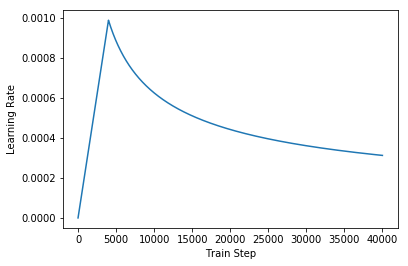

In [31]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [0]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_mean(loss_)

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

## Training and checkpointing

In [0]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, dropout_rate)

In [0]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [0]:
new_path = '../content/drive/My Drive/Neural_machine_translation/Transformer_model/checkpoints/'\
              +new_folder_name

if train_from_scratch == True:
  shutil.rmtree('../content/checkpoints')
  checkpoint_path = './checkpoints/train'
else:
  checkpoint_path = new_path +'/'+model_name

In [38]:
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if (ckpt_manager.latest_checkpoint):
  ckpt.restore(ckpt_manager.latest_checkpoint).expect_partial()
  print ('Latest checkpoint restored is {} !!'.format(ckpt_manager.latest_checkpoint.split('/')[-1]))
  print ('size of the checkpoint directory is {}MB '.format(sum(os.path.getsize(os.path.join(checkpoint_path,f)) for f in os.listdir(checkpoint_path))/(1024*1024)))

Latest checkpoint restored is ckpt-148 !!
size of the checkpoint directory is 789.6208267211914MB 


The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. `tar_real` is that same input shifted by 1: At each location in `tar_input`, `tar_real` contains the  next token that should be predicted.

For example, `sentence` = "SOS A lion in the jungle is sleeping EOS"

`tar_inp` =  "SOS A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping EOS"

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next. 

During training this example uses teacher-forcing (like in the [text generation tutorial](./text_generation.ipynb)). Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, *self-attention* allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peaking at the expected output the model uses a look-ahead mask.

## Evaluate

The following steps are used for evaluation:

* Encode the input sentence using the tamil3 tokenizer (`tokenizer_ta`). Moreover, add the start and end token so the input is equivalent to what the model is trained with. This is the encoder input.
* The decoder input is the `start token == tokenizer_en.vocab_size`.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Select the last word and calculate the argmax of that.
* Concatentate the predicted word to the decoder input as pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

Note: The model used here has less capacity to keep the example relatively faster so the predictions maybe less right. To reproduce the results in the paper, use the entire dataset and base transformer model or transformer XL, by changing the hyperparameters above.

In [0]:

#visualize train loss and Validation loss in tensorboard (@batch % 50 == 0)
#Follow karpthy's suggestion
#Small transformer model and feed it with a small data and increase the complexity untill the loss reaches zero
#Shuffle the 500K records and select 50K for training and select the best model (dataset.take(count))
#BLEU score code as evaluation metric for validation set
#beam_search decoder (paper highlights)
#use BERT to intialize weights (paper highlights) and train using TPU
#Publish paper , go through the IIT paper and get the results of validation and test
#Transformers with beamsearch



In [0]:
def evaluate(inp_sentence):
  start_token = [tokenizer_en.vocab_size]
  end_token = [tokenizer_en.vocab_size + 1]
  
  # inp sentence is english, hence adding the start and end token
  inp_sentence = start_token + tokenizer_en.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # as the target is tamil, the first word to the transformer should be the
  # english start token.
  decoder_input = [tokenizer_ta.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
  print(output.shape)
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if tf.equal(predicted_id, tokenizer_ta.vocab_size+1):
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [0]:

def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = tokenizer_ta.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[tokenizer_en.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([tokenizer_ta.decode([i]) for i in result 
                        if i < tokenizer_ta.vocab_size], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [0]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  
  predicted_sentence = tokenizer_ta.decode([i for i in result 
                                            if i < tokenizer_ta.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

In [0]:
# coding=utf-8
# Copyright 2018 The Tensor2Tensor Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Implementation of beam search with penalties."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math
import numpy as np

from tensor2tensor.layers import common_layers
import tensorflow as tf

from tensorflow.python.ops import inplace_ops
from tensorflow.python.util import nest

# Assuming EOS_ID is 1
EOS_ID = 1
# Default value for INF
INF = 1. * 1e7


def _merge_beam_dim(tensor):
  """Reshapes first two dimensions in to single dimension.

  Args:
    tensor: Tensor to reshape of shape [A, B, ...]

  Returns:
    Reshaped tensor of shape [A*B, ...]
  """
  shape = common_layers.shape_list(tensor)
  shape[0] *= shape[1]  # batch -> batch * beam_size
  shape.pop(1)  # Remove beam dim
  return tf.reshape(tensor, shape)


def _unmerge_beam_dim(tensor, batch_size, beam_size):
  """Reshapes first dimension back to [batch_size, beam_size].

  Args:
    tensor: Tensor to reshape of shape [batch_size*beam_size, ...]
    batch_size: Tensor, original batch size.
    beam_size: int, original beam size.

  Returns:
    Reshaped tensor of shape [batch_size, beam_size, ...]
  """
  shape = common_layers.shape_list(tensor)
  new_shape = [batch_size] + [beam_size] + shape[1:]
  return tf.reshape(tensor, new_shape)


def _expand_to_beam_size(tensor, beam_size):
  """Tiles a given tensor by beam_size.

  Args:
    tensor: tensor to tile [batch_size, ...]
    beam_size: How much to tile the tensor by.

  Returns:
    Tiled tensor [batch_size, beam_size, ...]
  """
  tensor = tf.expand_dims(tensor, axis=1)
  tile_dims = [1] * tensor.shape.ndims
  tile_dims[1] = beam_size

  return tf.tile(tensor, tile_dims)


def get_state_shape_invariants(tensor):
  """Returns the shape of the tensor but sets middle dims to None."""
  shape = tensor.shape.as_list()
  for i in range(1, len(shape) - 1):
    shape[i] = None
  return tf.TensorShape(shape)


def compute_batch_indices(batch_size, beam_size):
  """Computes the i'th coordinate that contains the batch index for gathers.

  Batch pos is a tensor like [[0,0,0,0,],[1,1,1,1],..]. It says which
  batch the beam item is in. This will create the i of the i,j coordinate
  needed for the gather.

  Args:
    batch_size: Batch size
    beam_size: Size of the beam.
  Returns:
    batch_pos: [batch_size, beam_size] tensor of ids
  """
  batch_pos = tf.range(batch_size * beam_size) // beam_size
  batch_pos = tf.reshape(batch_pos, [batch_size, beam_size])
  return batch_pos


def fast_tpu_gather(params, indices, name=None):
  """Fast gather implementation for models running on TPU.

  This function use one_hot and batch matmul to do gather, which is faster
  than gather_nd on TPU. For params that have dtype of int32 (sequences to
  gather from), batch_gather is used to keep accuracy.

  Args:
    params: A tensor from which to gather values.
      [batch_size, original_size, ...]
    indices: A tensor used as the index to gather values.
      [batch_size, selected_size].
    name: A string, name of the operation (optional).

  Returns:
    gather_result: A tensor that has the same rank as params.
      [batch_size, selected_size, ...]
  """
  with tf.compat.v1.name_scope(name):
    dtype = params.dtype

    def _gather(params, indices):
      """Fast gather using one_hot and batch matmul."""
      if dtype != tf.float32:
        params = tf.cast(params, dtype=tf.float32)
      shape = common_layers.shape_list(params)
      indices_shape = common_layers.shape_list(indices)
      ndims = params.shape.ndims
      # Adjust the shape of params to match one-hot indices, which is the
      # requirement of Batch MatMul.
      if ndims == 2:
        params = tf.expand_dims(params, axis=-1)
      if ndims > 3:
        params = tf.reshape(params, [shape[0], shape[1], -1])
      gather_result = tf.matmul(
          tf.one_hot(indices, shape[1], dtype=params.dtype), params)
      if ndims == 2:
        gather_result = tf.squeeze(gather_result, axis=-1)
      if ndims > 3:
        shape[1] = indices_shape[1]
        gather_result = tf.reshape(gather_result, shape)
      if dtype != tf.float32:
        gather_result = tf.cast(gather_result, dtype)
      return gather_result

    # If the dtype is int32, use the gather instead of one_hot matmul to avoid
    # precision loss. The max int value can be represented by bfloat16 in MXU is
    # 256, which is smaller than the possible id values. Encoding/decoding can
    # potentially used to make it work, but the benenfit is small right now.
    if dtype == tf.int32:
      gather_result = tf.compat.v1.batch_gather(params, indices)
    else:
      gather_result = _gather(params, indices)

    return gather_result


def _create_make_unique(inputs):
  """Replaces the lower bits of each element with iota.

  The iota is used to derive the index, and also serves the purpose to
  make each element unique to break ties.

  Args:
    inputs: A tensor with rank of 2 and dtype of tf.float32.
      [batch_size, original_size].

  Returns:
    A tensor after element wise transformation, with dtype the same as inputs.
    [batch_size, original_size].

  Raises:
    ValueError: If the rank of the input tensor does not equal 2.
  """
  if inputs.shape.ndims != 2:
    raise ValueError("Input of top_k_with_unique must be rank-2 "
                     "but got: %s" % inputs.shape)

  height = inputs.shape[0]
  width = inputs.shape[1]
  zeros = tf.zeros([height, width], dtype=tf.int32)

  # Count_mask is used to mask away the low order bits to ensure that every
  # element is distinct.
  log2_ceiling = int(math.ceil(math.log(int(width), 2)))
  next_power_of_two = 1 << log2_ceiling
  count_mask = ~(next_power_of_two - 1)
  count_mask_r0 = tf.constant(count_mask)
  count_mask_r2 = tf.fill([height, width], count_mask_r0)

  # Smallest_normal is the bit representation of the smallest positive normal
  # floating point number. The sign is zero, exponent is one, and the fraction
  # is zero.
  smallest_normal = 1 << 23
  smallest_normal_r0 = tf.constant(smallest_normal, dtype=tf.int32)
  smallest_normal_r2 = tf.fill([height, width], smallest_normal_r0)

  # Low_bit_mask is used to mask away the sign bit when computing the absolute
  # value.
  low_bit_mask = ~(1 << 31)
  low_bit_mask_r0 = tf.constant(low_bit_mask, dtype=tf.int32)
  low_bit_mask_r2 = tf.fill([height, width], low_bit_mask_r0)

  iota = tf.tile(tf.expand_dims(tf.range(width, dtype=tf.int32), 0),
                 [height, 1])

  # Compare the absolute value with positive zero to handle negative zero.
  input_r2 = tf.bitcast(inputs, tf.int32)
  abs_r2 = tf.bitwise.bitwise_and(input_r2, low_bit_mask_r2)
  if_zero_r2 = tf.equal(abs_r2, zeros)
  smallest_normal_preserving_sign_r2 = tf.bitwise.bitwise_or(
      input_r2, smallest_normal_r2)
  input_no_zeros_r2 = tf.compat.v1.where(
      if_zero_r2, smallest_normal_preserving_sign_r2, input_r2)

  # Discard the low-order bits and replace with iota.
  and_r2 = tf.bitwise.bitwise_and(input_no_zeros_r2, count_mask_r2)
  or_r2 = tf.bitwise.bitwise_or(and_r2, iota)
  return tf.bitcast(or_r2, tf.float32)


def _create_topk_unique(inputs, k):
  """Creates the top k values in sorted order with indices.

  Args:
    inputs: A tensor with rank of 2. [batch_size, original_size].
    k: An integer, number of top elements to select.

  Returns:
    topk_r2: A tensor, the k largest elements. [batch_size, k].
    topk_indices_r2: A tensor, indices of the top k values. [batch_size, k].
  """
  height = inputs.shape[0]
  width = inputs.shape[1]
  neg_inf_r0 = tf.constant(-np.inf, dtype=tf.float32)
  ones = tf.ones([height, width], dtype=tf.float32)
  neg_inf_r2 = ones * neg_inf_r0
  inputs = tf.compat.v1.where(tf.math.is_nan(inputs), neg_inf_r2, inputs)

  # Select the current largest value k times and keep them in topk_r2. The
  # selected largest values are marked as the smallest value to avoid being
  # selected again.
  tmp = inputs
  topk_r2 = tf.zeros([height, k], dtype=tf.float32)
  for i in range(k):
    kth_order_statistic = tf.reduce_max(input_tensor=tmp, axis=1, keepdims=True)
    k_mask = tf.tile(tf.expand_dims(tf.equal(tf.range(k), tf.fill([k], i)), 0),
                     [height, 1])
    topk_r2 = tf.compat.v1.where(k_mask, tf.tile(kth_order_statistic, [1, k]), topk_r2)
    ge_r2 = tf.greater_equal(inputs, tf.tile(kth_order_statistic, [1, width]))
    tmp = tf.compat.v1.where(ge_r2, neg_inf_r2, inputs)

  log2_ceiling = int(math.ceil(math.log(float(int(width)), 2)))
  next_power_of_two = 1 << log2_ceiling
  count_mask = next_power_of_two - 1
  mask_r0 = tf.constant(count_mask)
  mask_r2 = tf.fill([height, k], mask_r0)
  topk_r2_s32 = tf.bitcast(topk_r2, tf.int32)
  topk_indices_r2 = tf.bitwise.bitwise_and(topk_r2_s32, mask_r2)
  return topk_r2, topk_indices_r2


def top_k_with_unique(inputs, k):
  """Finds the values and indices of the k largests entries.

  Instead of doing sort like tf.nn.top_k, this function finds the max value
  k times. The running time is proportional to k, which is be faster when k
  is small. The current implementation supports only inputs of rank 2.
  In addition, iota is used to replace the lower bits of each element, this
  makes the selection more stable when there are equal elements. The
  overhead is that output values are approximated.

  Args:
    inputs: A tensor with rank of 2. [batch_size, original_size].
    k: An integer, number of top elements to select.

  Returns:
    top_values: A tensor, the k largest elements in sorted order.
      [batch_size, k].
    indices: A tensor, indices of the top_values. [batch_size, k].
  """
  unique_inputs = _create_make_unique(tf.cast(inputs, tf.float32))
  top_values, indices = _create_topk_unique(unique_inputs, k)
  top_values = tf.cast(top_values, inputs.dtype)
  return top_values, indices


def compute_topk_scores_and_seq(sequences, scores, scores_to_gather, flags,
                                beam_size, batch_size, prefix="default",
                                states_to_gather=None, use_tpu=False):
  """Given sequences and scores, will gather the top k=beam size sequences.

  This function is used to grow alive, and finished. It takes sequences,
  scores, and flags, and returns the top k from sequences, scores_to_gather,
  and flags based on the values in scores.

  This method permits easy introspection using tfdbg.  It adds three named ops
  that are prefixed by `prefix`:
    - _topk_seq: the tensor for topk_seq returned by this method.
    - _topk_flags: the tensor for topk_finished_flags returned by this method.
    - _topk_scores: the tensor for tokp_gathered_scores returned by this method.

  Args:
    sequences: Tensor of sequences that we need to gather from.
      [batch_size, beam_size, seq_length]
    scores: Tensor of scores for each sequence in sequences.
      [batch_size, beam_size]. We will use these to compute the topk.
    scores_to_gather: Tensor of scores for each sequence in sequences.
      [batch_size, beam_size]. We will return the gathered scores from here.
      Scores to gather is different from scores because for grow_alive, we will
      need to return log_probs, while for grow_finished, we will need to return
      the length penalized scores.
    flags: Tensor of bools for sequences that say whether a sequence has reached
      EOS or not
    beam_size: int
    batch_size: int
    prefix: string that will prefix unique names for the ops run.
    states_to_gather: dict (possibly nested) of decoding states.
    use_tpu: A bool, whether to compute topk scores and sequences on TPU.

  Returns:
    Tuple of
    (topk_seq [batch_size, beam_size, decode_length],
     topk_gathered_scores [batch_size, beam_size],
     topk_finished_flags[batch_size, beam_size])
  """
  if not use_tpu:
    _, topk_indexes = tf.nn.top_k(scores, k=beam_size)
    # The next three steps are to create coordinates for tf.gather_nd to pull
    # out the topk sequences from sequences based on scores.
    # batch pos is a tensor like [[0,0,0,0,],[1,1,1,1],..]. It says which
    # batch the beam item is in. This will create the i of the i,j coordinate
    # needed for the gather
    batch_pos = compute_batch_indices(batch_size, beam_size)

    # top coordinates will give us the actual coordinates to do the gather.
    # stacking will create a tensor of dimension batch * beam * 2, where the
    # last dimension contains the i,j gathering coordinates.
    top_coordinates = tf.stack([batch_pos, topk_indexes], axis=2)

    # Gather up the highest scoring sequences.  For each operation added, give
    # it a concrete name to simplify observing these operations with tfdbg.
    # Clients can capture these tensors by watching these node names.
    def gather(tensor, name):
      return tf.gather_nd(tensor, top_coordinates, name=(prefix + name))
    topk_seq = gather(sequences, "_topk_seq")
    topk_flags = gather(flags, "_topk_flags")
    topk_gathered_scores = gather(scores_to_gather, "_topk_scores")
    if states_to_gather:
      topk_gathered_states = nest.map_structure(
          lambda state: gather(state, "_topk_states"), states_to_gather)
    else:
      topk_gathered_states = states_to_gather
  else:
    _, topk_indexes = top_k_with_unique(scores, k=beam_size)
    # Gather up the highest scoring sequences.  For each operation added, give
    # it a concrete name to simplify observing these operations with tfdbg.
    # Clients can capture these tensors by watching these node names.
    topk_seq = fast_tpu_gather(sequences, topk_indexes, prefix + "_topk_seq")
    topk_flags = fast_tpu_gather(flags, topk_indexes, prefix + "_topk_flags")
    topk_gathered_scores = fast_tpu_gather(scores_to_gather, topk_indexes,
                                           prefix + "_topk_scores")
    if states_to_gather:
      topk_gathered_states = nest.map_structure(
          # pylint: disable=g-long-lambda
          lambda state: fast_tpu_gather(state, topk_indexes,
                                        prefix + "_topk_states"),
          states_to_gather)
    else:
      topk_gathered_states = states_to_gather
  return topk_seq, topk_gathered_scores, topk_flags, topk_gathered_states


def beam_search(symbols_to_logits_fn,
                initial_ids,
                beam_size,
                decode_length,
                vocab_size,
                alpha,
                states=None,
                eos_id=EOS_ID,
                stop_early=True,
                use_tpu=False):
  """Beam search with length penalties.

  Requires a function that can take the currently decoded symbols and return
  the logits for the next symbol. The implementation is inspired by
  https://arxiv.org/abs/1609.08144.

  When running, the beam search steps can be visualized by using tfdbg to watch
  the operations generating the output ids for each beam step.  These operations
  have the pattern:
    (alive|finished)_topk_(seq,scores)

  Operations marked `alive` represent the new beam sequences that will be
  processed in the next step.  Operations marked `finished` represent the
  completed beam sequences, which may be padded with 0s if no beams finished.

  Operations marked `seq` store the full beam sequence for the time step.
  Operations marked `scores` store the sequence's final log scores.

  The beam search steps will be processed sequentially in order, so when
  capturing observed from these operations, tensors, clients can make
  assumptions about which step is being recorded.

  WARNING: Assumes 2nd dimension of tensors in `states` and not invariant, this
  means that the shape of the 2nd dimension of these tensors will not be
  available (i.e. set to None) inside symbols_to_logits_fn.

  Args:
    symbols_to_logits_fn: Interface to the model, to provide logits.
        Shoud take [batch_size, decoded_ids] and return [batch_size, vocab_size]
    initial_ids: Ids to start off the decoding, this will be the first thing
        handed to symbols_to_logits_fn (after expanding to beam size)
        [batch_size]
    beam_size: Size of the beam.
    decode_length: Number of steps to decode for.
    vocab_size: Size of the vocab, must equal the size of the logits returned by
        symbols_to_logits_fn
    alpha: alpha for length penalty.
    states: dict (possibly nested) of decoding states.
    eos_id: ID for end of sentence.
    stop_early: a boolean - stop once best sequence is provably determined.
    use_tpu: A bool, whether to do beam search on TPU.

  Returns:
    Tuple of
    (decoded beams [batch_size, beam_size, decode_length]
     decoding probabilities [batch_size, beam_size])
  """
  batch_size = common_layers.shape_list(initial_ids)[0]

  # Assume initial_ids are prob 1.0
  initial_log_probs = tf.constant([[0.] + [-INF] * (beam_size - 1)])
  # Expand to beam_size (batch_size, beam_size)
  alive_log_probs = tf.tile(initial_log_probs, [batch_size, 1])

  # Expand each batch and state to beam_size
  alive_seq = _expand_to_beam_size(initial_ids, beam_size)
  alive_seq = tf.expand_dims(alive_seq, axis=2)  # (batch_size, beam_size, 1)
  if use_tpu:
    alive_seq = tf.tile(alive_seq, [1, 1, decode_length + 1])
  if states:
    states = nest.map_structure(
        lambda state: _expand_to_beam_size(state, beam_size), states)
  else:
    states = {}

  # Finished will keep track of all the sequences that have finished so far
  # Finished log probs will be negative infinity in the beginning
  # finished_flags will keep track of booleans
  finished_seq = tf.zeros(common_layers.shape_list(alive_seq), tf.int32)
  # Setting the scores of the initial to negative infinity.
  finished_scores = tf.ones([batch_size, beam_size]) * -INF
  finished_flags = tf.zeros([batch_size, beam_size], tf.bool)

  def grow_finished(finished_seq, finished_scores, finished_flags, curr_seq,
                    curr_scores, curr_finished):
    """Given sequences and scores, will gather the top k=beam size sequences.

    Args:
      finished_seq: Current finished sequences.
        [batch_size, beam_size, current_decoded_length]
      finished_scores: scores for each of these sequences.
        [batch_size, beam_size]
      finished_flags: finished bools for each of these sequences.
        [batch_size, beam_size]
      curr_seq: current topk sequence that has been grown by one position.
        [batch_size, beam_size, current_decoded_length]
      curr_scores: scores for each of these sequences. [batch_size, beam_size]
      curr_finished: Finished flags for each of these sequences.
        [batch_size, beam_size]
    Returns:
      Tuple of
        (Topk sequences based on scores,
         log probs of these sequences,
         Finished flags of these sequences)
    """
    if not use_tpu:
      # First append a column of 0'ids to finished to make the same length with
      # finished scores
      finished_seq = tf.concat(
          [finished_seq,
           tf.zeros([batch_size, beam_size, 1], tf.int32)], axis=2)

    # Set the scores of the unfinished seq in curr_seq to large negative
    # values
    curr_scores += (1. - tf.cast(curr_finished, dtype=tf.float32)) * -INF
    # concatenating the sequences and scores along beam axis
    curr_finished_seq = tf.concat([finished_seq, curr_seq], axis=1)
    curr_finished_scores = tf.concat([finished_scores, curr_scores], axis=1)
    curr_finished_flags = tf.concat([finished_flags, curr_finished], axis=1)
    return compute_topk_scores_and_seq(
        curr_finished_seq, curr_finished_scores, curr_finished_scores,
        curr_finished_flags, beam_size, batch_size, "grow_finished",
        use_tpu=use_tpu)

  def grow_alive(curr_seq, curr_scores, curr_log_probs, curr_finished, states):
    """Given sequences and scores, will gather the top k=beam size sequences.

    Args:
      curr_seq: current topk sequence that has been grown by one position.
        [batch_size, beam_size, i+1]
      curr_scores: scores for each of these sequences. [batch_size, beam_size]
      curr_log_probs: log probs for each of these sequences.
        [batch_size, beam_size]
      curr_finished: Finished flags for each of these sequences.
        [batch_size, beam_size]
      states: dict (possibly nested) of decoding states.
    Returns:
      Tuple of
        (Topk sequences based on scores,
         log probs of these sequences,
         Finished flags of these sequences)
    """
    # Set the scores of the finished seq in curr_seq to large negative
    # values
    curr_scores += tf.cast(curr_finished, dtype=tf.float32) * -INF
    return compute_topk_scores_and_seq(curr_seq, curr_scores, curr_log_probs,
                                       curr_finished, beam_size, batch_size,
                                       "grow_alive", states, use_tpu=use_tpu)

  def grow_topk(i, alive_seq, alive_log_probs, states):
    r"""Inner beam search loop.

    This function takes the current alive sequences, and grows them to topk
    sequences where k = 2*beam. We use 2*beam because, we could have beam_size
    number of sequences that might hit <EOS> and there will be no alive
    sequences to continue. With 2*beam_size, this will not happen. This relies
    on the assumption the vocab size is > beam size. If this is true, we'll
    have at least beam_size non <EOS> extensions if we extract the next top
    2*beam words.
    Length penalty is given by = (5+len(decode)/6) ^ -\alpha. Pls refer to
    https://arxiv.org/abs/1609.08144.

    Args:
      i: loop index
      alive_seq: Topk sequences decoded so far [batch_size, beam_size, i+1]
      alive_log_probs: probabilities of these sequences. [batch_size, beam_size]
      states: dict (possibly nested) of decoding states.
    Returns:
      Tuple of
        (Topk sequences extended by the next word,
         The log probs of these sequences,
         The scores with length penalty of these sequences,
         Flags indicating which of these sequences have finished decoding,
         dict of transformed decoding states)
    """
    # Get the logits for all the possible next symbols
    if use_tpu and states:
      flat_ids = tf.reshape(
          tf.slice(alive_seq, [0, 0, i], [batch_size, beam_size, 1]),
          [batch_size * beam_size, -1])
    else:
      flat_ids = tf.reshape(alive_seq, [batch_size * beam_size, -1])

    # (batch_size * beam_size, decoded_length)
    if states:
      flat_states = nest.map_structure(_merge_beam_dim, states)
      flat_logits, flat_states = symbols_to_logits_fn(flat_ids, i, flat_states)
      states = nest.map_structure(
          lambda t: _unmerge_beam_dim(t, batch_size, beam_size), flat_states)
    elif use_tpu:
      flat_logits = symbols_to_logits_fn(flat_ids, i)
    else:
      flat_logits = symbols_to_logits_fn(flat_ids)

    logits = tf.reshape(flat_logits, [batch_size, beam_size, -1])

    # Convert logits to normalized log probs
    candidate_log_probs = common_layers.log_prob_from_logits(logits)

    # Multiply the probabilities by the current probabilities of the beam.
    # (batch_size, beam_size, vocab_size) + (batch_size, beam_size, 1)
    log_probs = candidate_log_probs + tf.expand_dims(alive_log_probs, axis=2)

    length_penalty = tf.pow(((5. + tf.cast(i + 1, dtype=tf.float32)) / 6.), alpha)

    curr_scores = log_probs / length_penalty
    # Flatten out (beam_size, vocab_size) probs in to a list of possibilities
    flat_curr_scores = tf.reshape(curr_scores, [-1, beam_size * vocab_size])

    if use_tpu:
      topk_scores, topk_ids = top_k_with_unique(
          flat_curr_scores, k=beam_size * 2)
    else:
      topk_scores, topk_ids = tf.nn.top_k(flat_curr_scores, k=beam_size * 2)

    # Recovering the log probs because we will need to send them back
    topk_log_probs = topk_scores * length_penalty

    # Work out what beam the top probs are in.
    topk_beam_index = topk_ids // vocab_size
    topk_ids %= vocab_size  # Unflatten the ids

    if not use_tpu:
      # The next three steps are to create coordinates for tf.gather_nd to pull
      # out the correct sequences from id's that we need to grow.
      # We will also use the coordinates to gather the booleans of the beam
      # items that survived.
      batch_pos = compute_batch_indices(batch_size, beam_size * 2)

      # top beams will give us the actual coordinates to do the gather.
      # stacking will create a tensor of dimension batch * beam * 2, where the
      # last dimension contains the i,j gathering coordinates.
      topk_coordinates = tf.stack([batch_pos, topk_beam_index], axis=2)

      # Gather up the most probable 2*beams both for the ids and
      # finished_in_alive bools
      topk_seq = tf.gather_nd(alive_seq, topk_coordinates)
      if states:
        states = nest.map_structure(
            lambda state: tf.gather_nd(state, topk_coordinates), states)

      # Append the most probable alive
      topk_seq = tf.concat([topk_seq, tf.expand_dims(topk_ids, axis=2)], axis=2)
    else:
      # Gather up the most probable 2*beams both for the ids and
      # finished_in_alive bools
      topk_seq = fast_tpu_gather(alive_seq, topk_beam_index)

      if states:
        states = nest.map_structure(
            lambda state: fast_tpu_gather(state, topk_beam_index), states)

      # Update the most probable alive
      topk_seq = tf.transpose(a=topk_seq, perm=[2, 0, 1])
      topk_seq = inplace_ops.alias_inplace_update(topk_seq, i + 1, topk_ids)
      topk_seq = tf.transpose(a=topk_seq, perm=[1, 2, 0])

    topk_finished = tf.equal(topk_ids, eos_id)

    return topk_seq, topk_log_probs, topk_scores, topk_finished, states

  def inner_loop(i, alive_seq, alive_log_probs, finished_seq, finished_scores,
                 finished_flags, states):
    """Inner beam search loop.

    There are three groups of tensors, alive, finished, and topk.
    The alive group contains information about the current alive sequences
    The topk group contains information about alive + topk current decoded words
    the finished group contains information about finished sentences, that is,
    the ones that have decoded to <EOS>. These are what we return.
    The general beam search algorithm is as follows:
    While we haven't terminated (pls look at termination condition)
      1. Grow the current alive to get beam*2 topk sequences
      2. Among the topk, keep the top beam_size ones that haven't reached EOS
      into alive
      3. Among the topk, keep the top beam_size ones have reached EOS into
      finished
    Repeat
    To make things simple with using fixed size tensors, we will end
    up inserting unfinished sequences into finished in the beginning. To stop
    that we add -ve INF to the score of the unfinished sequence so that when a
    true finished sequence does appear, it will have a higher score than all the
    unfinished ones.

    Args:
      i: loop index
      alive_seq: Topk sequences decoded so far [batch_size, beam_size, i+1]
      alive_log_probs: probabilities of the beams. [batch_size, beam_size]
      finished_seq: Current finished sequences.
        [batch_size, beam_size, i+1]
      finished_scores: scores for each of these sequences.
        [batch_size, beam_size]
      finished_flags: finished bools for each of these sequences.
        [batch_size, beam_size]
      states: dict (possibly nested) of decoding states.

    Returns:
      Tuple of
        (Incremented loop index
         New alive sequences,
         Log probs of the alive sequences,
         New finished sequences,
         Scores of the new finished sequences,
         Flags indicating which sequence in finished as reached EOS,
         dict of final decoding states)
    """

    # Each inner loop, we carry out three steps:
    # 1. Get the current topk items.
    # 2. Extract the ones that have finished and haven't finished
    # 3. Recompute the contents of finished based on scores.
    topk_seq, topk_log_probs, topk_scores, topk_finished, states = grow_topk(
        i, alive_seq, alive_log_probs, states)
    alive_seq, alive_log_probs, _, states = grow_alive(
        topk_seq, topk_scores, topk_log_probs, topk_finished, states)
    finished_seq, finished_scores, finished_flags, _ = grow_finished(
        finished_seq, finished_scores, finished_flags, topk_seq, topk_scores,
        topk_finished)

    return (i + 1, alive_seq, alive_log_probs, finished_seq, finished_scores,
            finished_flags, states)

  def _is_finished(i, unused_alive_seq, alive_log_probs, unused_finished_seq,
                   finished_scores, finished_in_finished, unused_states):
    """Checking termination condition.

    We terminate when we decoded up to decode_length or the lowest scoring item
    in finished has a greater score that the highest prob item in alive divided
    by the max length penalty

    Args:
      i: loop index
      alive_log_probs: probabilities of the beams. [batch_size, beam_size]
      finished_scores: scores for each of these sequences.
        [batch_size, beam_size]
      finished_in_finished: finished bools for each of these sequences.
        [batch_size, beam_size]

    Returns:
      Bool.
    """
    if not stop_early:
      return tf.less(i, decode_length)
    max_length_penalty = tf.pow(((5. + tf.cast(decode_length, dtype=tf.float32)) / 6.), alpha)
    # The best possible score of the most likely alive sequence.
    lower_bound_alive_scores = alive_log_probs[:, 0] / max_length_penalty

    # Now to compute the lowest score of a finished sequence in finished
    # If the sequence isn't finished, we multiply it's score by 0. since
    # scores are all -ve, taking the min will give us the score of the lowest
    # finished item.
    lowest_score_of_finished_in_finished = tf.reduce_min(
        input_tensor=finished_scores * tf.cast(finished_in_finished, dtype=tf.float32), axis=1)
    # If none of the sequences have finished, then the min will be 0 and
    # we have to replace it by -ve INF if it is. The score of any seq in alive
    # will be much higher than -ve INF and the termination condition will not
    # be met.
    lowest_score_of_finished_in_finished += (
        (1. - tf.cast(tf.reduce_any(input_tensor=finished_in_finished, axis=1), dtype=tf.float32)) * -INF)

    bound_is_met = tf.reduce_all(
        input_tensor=tf.greater(lowest_score_of_finished_in_finished,
                   lower_bound_alive_scores))

    return tf.logical_and(
        tf.less(i, decode_length), tf.logical_not(bound_is_met))

  (_, alive_seq, alive_log_probs, finished_seq, finished_scores,
   finished_flags, _) = tf.while_loop(
       cond=_is_finished,
       body=inner_loop, loop_vars=[
           tf.constant(0), alive_seq, alive_log_probs, finished_seq,
           finished_scores, finished_flags, states
       ],
       shape_invariants=[
           tf.TensorShape([]),
           (tf.TensorShape([batch_size, beam_size, decode_length + 1])
            if use_tpu else tf.TensorShape([None, None, None])),
           alive_log_probs.get_shape(),
           (tf.TensorShape([batch_size, beam_size, decode_length + 1])
            if use_tpu else tf.TensorShape([None, None, None])),
           finished_scores.get_shape(),
           finished_flags.get_shape(),
           (nest.map_structure(lambda state: state.get_shape(), states)
            if use_tpu else
            nest.map_structure(get_state_shape_invariants, states)),
       ],
       parallel_iterations=1,
       back_prop=False)

  alive_seq.set_shape((None, beam_size, None))
  finished_seq.set_shape((None, beam_size, None))

  # Accounting for corner case: It's possible that no sequence in alive for a
  # particular batch item ever reached EOS. In that case, we should just copy
  # the contents of alive for that batch item. tf.reduce_any(finished_flags, 1)
  # if 0, means that no sequence for that batch index had reached EOS. We need
  # to do the same for the scores as well.
  finished_seq = tf.compat.v1.where(
      tf.reduce_any(input_tensor=finished_flags, axis=1), finished_seq, alive_seq)
  finished_scores = tf.compat.v1.where(
      tf.reduce_any(input_tensor=finished_flags, axis=1), finished_scores, alive_log_probs)
  return finished_seq, finished_scores


In [0]:
beam_size = 7
batch_size = 1
inp_sentence = "you should do well"
greed_ip = inp_sentence
start_token = [tokenizer_en.vocab_size]
end_token = [tokenizer_en.vocab_size + 1]
inp_sentence = start_token + tokenizer_en.encode(inp_sentence) + end_token
encoder_input = tf.expand_dims(inp_sentence, 0)
encoder_input = tf.concat([encoder_input]*beam_size, axis=0)
def transformer_query(output):
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  predictions, attention_weights = transformer(encoder_input, 
                                               output,
                                               False,
                                               enc_padding_mask,
                                               combined_mask,
                                               dec_padding_mask)
 

  return (predictions[:,-1:,:])

In [198]:
start = tokenizer_ta.vocab_size
end = tokenizer_ta.vocab_size+1

#initial_ids = tf.constant([start])
a=beam_search(transformer_query, [start], beam_size, 50, target_vocab_size,0.6,eos_id=[tokenizer_ta.vocab_size+1])

print(tokenizer_ta.decode([j for j in a[0][0][0].numpy() if j < tokenizer_ta.vocab_size]))

நீங்கள் செய்ய வேண்டும்


In [191]:
translate(greed_ip)

(1, 1)
Input: you should do well
Predicted translation: நீங்கள் சரியான செய்ய வேண்டும்


In [0]:
# def beam_search(prev, i):
#   batch_size = 1
#   beam_size = 3  # Number of hypotheses in beam
#   vocab_size = target_vocab_size  # tamil vocabulary size
#   num_steps = MAX_LENGTH # MAX_LENGTH
#   embedding_size = d_model#dmodel 256
#   embedding = transformer.decoder.get_weights()[0]  
#   W =  tf.random.normal([embedding_size, vocab_size], mean=2, stddev=1, dtype=tf.float32, seed=0)
#   b =  tf.random.normal([vocab_size], mean=0, stddev=1, dtype=tf.float32, seed=0)
#   index_base = tf.reshape(
#     tf.tile(tf.expand_dims(tf.range(batch_size) * beam_size, axis=1), [1, beam_size]), [-1])
#   log_beam_probs, beam_symbols = [], []
#   if i > 1:# total probability
#     prev = tf.compat.v1.nn.xw_plus_b(prev, W, b)
#     log_probs = tf.nn.log_softmax(prev) 
#     log_probs = tf.reshape(tf.reduce_sum(input_tensor=tf.stack(log_beam_probs, axis=1), axis=1) + log_probs,
# 							   [-1, beam_size * vocab_size])
#     # (batch_size*beam_size, vocab_size) -> (batch_size, beam_size*vocab_size)
#   else:
#     log_probs = tf.nn.log_softmax(prev)
    
#   best_probs, indices = tf.nn.top_k(log_probs, beam_size)
#   # (batch_size, beam_size)
#   indices = tf.squeeze(tf.reshape(indices, [-1, 1]))
#   best_probs = tf.reshape(best_probs, [-1, 1])
#   #print()
#   # (batch_size*beam_size)
#   symbols = indices % vocab_size       # which word in vocabulary
#   beam_parent = indices // vocab_size  # which hypothesis it came from
#   beam_symbols.append(symbols)
#   #print(log_probs)
#   real_path = beam_parent + index_base
#   # get rid of the previous probability
#   if i > 1:
#     pre_sum = tf.reduce_sum(input_tensor=tf.stack(log_beam_probs, axis=1), axis=1)
#     pre_sum = tf.gather(pre_sum, real_path)
#   else:
#     pre_sum = 0
#   log_beam_probs.append(best_probs-pre_sum)
#   if i > 1:
#     for j in range(i)[:0:-1]:
#       beam_symbols[j-1] = tf.gather(beam_symbols[j-1], real_path)
#       log_beam_probs[j-1] = tf.gather(log_beam_probs[j-1], real_path)
#   return tf.nn.embedding_lookup(params=embedding, ids=symbols), beam_symbols

In [0]:
# def evaluate(inp_sentence):
#   start_token = [tokenizer_en.vocab_size]
#   end_token = [tokenizer_en.vocab_size + 1]
  
#   # inp sentence is tamil, hence adding the start and end token
#   inp_sentence = start_token + tokenizer_en.encode(inp_sentence) + end_token
#   encoder_input = tf.expand_dims(inp_sentence, 0)
  
#   # as the target is english, the first word to the transformer should be the
#   # english start token.
#   decoder_input = [tokenizer_ta.vocab_size]
#   output = tf.expand_dims(decoder_input, 0)
    
#   for i in range(MAX_LENGTH):
#     enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
#         encoder_input, output)
  
#     # predictions.shape == (batch_size, seq_len, vocab_size)
#     predictions, attention_weights = transformer(encoder_input, 
#                                                  output,
#                                                  False,
#                                                  enc_padding_mask,
#                                                  combined_mask,
#                                                  dec_padding_mask)
#     predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
#     #print('predictions')
#     #print(predictions)
#     if i==0:
#       bpredictions = predictions
#     bpredictions,beam_symbols = beam_search(bpredictions, i+1)  #next_input should be predictions(transformer op) (logits)
#     #print(best_seq)
#     seq_rank = tf.stack(values=beam_symbols)

#   return seq_rank